# Data Augmentation through Stable Diffussion Inpainting

In [1]:
!pip install -q diffusers transformers accelerate scipy safetensors
!pip install -q ninja
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-chqfc94h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-chqfc94h
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done


In [2]:
import os
import random
from torchvision.datasets import CocoDetection
from PIL import Image

In [3]:
def bold(text):
    return '\033[1m' + text + '\033[0m'

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [4]:
import re 
from tqdm import tqdm 
import random 
from nltk import word_tokenize

tokenizer = lambda x: word_tokenize(x)

def remove_elt(l, e):
    l.remove(e)
    return l

class skillsChecker():
    """
    Class to detect if a skill is present in a text, and change it accoordingly. 
    
    This version is not using regex to detect and change words, it should work for gender, color, counting. 
    It will not be efficient for the emotion. To test what is present in the caption dataset. 
    
    ```
    self.list_skills = {
        skill_i : [token_i_1, token_i_2, ...], 
        skill_j : list_tokens_to_check_j, 
        ...
    }
    ```
    
    ```
    self.list_change = {
        skill_i : { 
            token_i_1 : list_possible_change_for_token_i_1,
            token_i_2 : list_possible_change_for_token_i_2,
            ...
        },
        skill_j  : { 
            token_j_1 : list_possible_change_for_token_j_1,
            ...
        },
        ...
    }
    ```
    
    """
    def __init__(self):
        
        # list of words to check
        self.list_skills = {
            'gender' : ['boy', 'boys', 'man', 'men', 'guy', 'guys', 'girl', 'girls', 'woman', 'women'], 
            'emotion' : ['angry', 'happy', 'sad', 'disgut*', 'surprised', 'fear'],  # easier with visual emotion recognition ? 
            'counting' : ['two', 'three', 'four', 'five', 'six'],
            'color' : ['red', 'green', 'blue', 'yellow', 'purple'] #+ ['black', 'white', 'orange']
            ,
        }
        self.list_change = {
            'gender': {
                'boy' : ['girl'], 
                'boys' : ['girls'], 
                'man' : ['woman'], 
                'men' : ['women'], 
                'guy' : ['girl'], 
                'guys' : ['girls'],
                'girl' : ['boy'], 
                'girls' : ['boys'], 
                'woman' : ['man'], 
                'women' : ['men'],
            },
            'color' : { # hopefully no MWE like green light, hard to detect with pos-tagger... 
                color : remove_elt(self.list_skills['color'].copy(), color) for color in self.list_skills['color']
            },
            'counting' : {
                'two' : ['three'],
                'three' : ['two', 'four'],
                'four' : ['three', 'five'],
                'five' : ['four', 'six'],
                'six' : ['five']
            },
            'emotion' : { # hard to see how well this will work... to test! 
                emotion : remove_elt(self.list_skills['emotion'].copy(), emotion) for emotion in self.list_skills['emotion']
            }
        }
    
    def find_captions_skill(self, list_captions, skill, verbose=False):
        """
        find the captions that contains a special skill
        output:
        list_captions_kept: list of the captions containing the skill
        list_words_skill: list of boolean lists regarding which skill-related word was found in each sentence   
        """
        if verbose: list_captions = tqdm(list_captions)
            
        # list of boolean values regarding the skill is here
        list_bool_skill = []
        list_words_skill = []
        
        for capt in list_captions:
            # tokenize and put in lower in order to find the words
            capt = [tok.lower() for tok in tokenizer(capt)]
            
            list_booleans = [skill_wd in capt for skill_wd in self.list_skills[skill]]
            is_skill = any(list_booleans)
            list_bool_skill.append(is_skill)
            if is_skill:
                # list_words_skill.append(self.list_skills[skill][list_booleans])
                list_words_skill.append([a for a, b in zip(self.list_skills[skill], list_booleans) if b])
            
        list_captions_kept = [a for a, b in zip(list_captions, list_bool_skill) if b]
        
        return list_captions_kept, list_words_skill
    
    def find_captions_all_skills(self, list_captions):
        """
        All skills at once 
        """
        dict_bool_skills = {sk : [] for sk in self.list_skills.keys()}
        dict_words_skills = {sk : [] for sk in self.list_skills.keys()}

        for sk, skill_wds in list_skills.items():
            dict_captions_skills[sk], dict_words_skills[sk] = self.find_captions_skill(list_captions, sk)
                
        return dict_captions_skills, dict_words_skills
                
    def change_captions_skill(self, list_captions, skill):
        """
        output: 
        list_captions_skill_changed: list of n-uples containing the new captions for the skill in question 
        """
        
        list_captions_skill, list_words_skill = self.find_captions_skill(list_captions, skill)
        
        # all the captions changed
        list_captions_skill_changed = []
        
        for capt, list_word_skill in zip(list_captions_skill, list_words_skill):
            
            # one caption many variations 
            list_one_caption_changed = []
            for wd in list_word_skill:  
                wd_to_sub = random.choice(self.list_change[skill][wd])
                
                # to keep the capitalization of the first letter
                # new_caption = re.sub(r'\b[%s%s]%s\b'%(wd[0].upper(), wd[0], wd[1:]), wd_to_sub, capt)
                new_caption = re.sub(r'\b%s\b'%wd, wd_to_sub, capt)
                if new_caption == capt:
                    wd = wd.capitalize()
                    wd_to_sub = wd_to_sub.capitalize()
                    new_caption = re.sub(r'\b%s\b'%wd, wd_to_sub, capt)
                list_one_caption_changed.append(new_caption)
                # print(wd, wd_to_sub, capt, '\n', list_one_caption_changed[-1])
            list_captions_skill_changed.append(list_one_caption_changed)
            
        return [(a,b) for a,b in zip(list_captions_skill, list_captions_skill_changed)]

## Downloading the Coco Dataset

In [5]:
base_dir = '/mnt/nas2/GrimaRepo/datasets/mscoco/coco2014'
images_dir = f'{base_dir}/train2014/'
annotations_path = f'{base_dir}/annotations/instances_train2014.json'
captions_path = f'{base_dir}/annotations/captions_train2014.json'

In [6]:
if not os.path.exists(base_dir):
    !mkdir {base_dir}
if not os.path.exists(annotations_path):
    !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P {base_dir}
    !unzip -q data/annotations_trainval2014.zip -d {base_dir}

In [7]:
if not os.path.exists(images_dir):
    !mkdir {images_dir}
    !wget http://images.cocodataset.org/zips/train2014.zip -P {base_dir}
    !unzip -q data/train2014.zip -d {base_dir}

## Load Dataset and Obtaining Elements

In [8]:
from pycocotools.coco import COCO
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [9]:
# coco_ds = CocoDetection(images_dir, annotations_path)
coco = COCO(annotations_path)
coco_captions = COCO(captions_path)

loading annotations into memory...
Done (t=12.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [10]:
categories = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in categories]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in categories])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
animal person furniture appliance accessory kitchen electronic indoor outdoor food vehicle sports


## Create Stable Diffusion Pipeline

In [11]:
import torch
from diffusers import StableDiffusionInpaintPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2022-12-30 16:41:30.212251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64/
2022-12-30 16:41:30.212291: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    # "stabilityai/stable-diffusion-2-inpainting",
    "runwayml/stable-diffusion-inpainting",
    revision="fp16", 
    torch_dtype=torch.float16,
    cache_dir='./models/'
).to(device)
# pipe.enable_attention_slicing() # Use if limited GPU memory

## Create CLIP Model

In [13]:
import clip
clip_model, preprocess = clip.load('RN50x64', download_root='./models/')
clip_model = clip_model.to(device).eval()

## Select an element from Coco Dataset

In [14]:
from IPython.display import display
import ipywidgets as widgets
category_options = ([""] + sorted([cat['name'] for cat in categories]))
category_select = widgets.Dropdown(
    options=category_options,
    value="person",
    description='Category:',
    layout=widgets.Layout(width='30%', object_position='left')
)

In [15]:
display(category_select)

Dropdown(description='Category:', index=50, layout=Layout(object_position='left', width='30%'), options=('', '…

In [16]:
selected_category = category_select.value
if selected_category:
    selected_category_id = coco.getCatIds(catNms=[selected_category])
    image_ids = coco.getImgIds(catIds=selected_category_id)
else:
    image_ids = coco.getImgIds()

random_select = widgets.Checkbox(
    value=False,
    description='Random element ',
    layout=widgets.Layout(width='30%', object_position='left')
)
id_slider = widgets.SelectionSlider(
    options=sorted(image_ids),
    description='Id:',
    layout=widgets.Layout(width='30%', object_position='left')
)
display(widgets.VBox([random_select, id_slider]))

In [17]:
# imgIds = coco.getImgIds(imgIds = [324158])
choose_randomly = random_select.value
element_id = image_ids[np.random.randint(0, len(image_ids))] if choose_randomly else id_slider.value

print(f"Loading element with id: {element_id}")

image_data = coco.loadImgs(element_id)[0]
image_filename = image_data['file_name']
image = Image.open(f'{images_dir}/{image_filename}')

labels_ids = coco.getAnnIds(imgIds=image_data['id'], iscrowd=None)
labels = coco.loadAnns(labels_ids)

captions_ids = coco_captions.getAnnIds(imgIds=image_data['id'], iscrowd=None)
captions = coco_captions.loadAnns(captions_ids)

Loading element with id: 36


In [44]:
labels

[{'segmentation': [[164.5,
    479.38,
    120.26,
    448.4,
    93.7,
    442.87,
    91.5,
    440.65,
    36.17,
    383.12,
    28.43,
    384.23,
    35.06,
    382.02,
    4.1,
    307.89,
    9.62,
    297.94,
    6.3,
    224.92,
    0.0,
    224.92,
    9.62,
    219.4,
    38.39,
    146.38,
    52.77,
    143.06,
    111.4,
    88.85,
    106.97,
    78.89,
    119.16,
    83.32,
    204.34,
    61.2,
    203.23,
    50.12,
    208.76,
    57.87,
    302.8,
    70.04,
    302.8,
    63.4,
    306.12,
    71.15,
    383.55,
    120.92,
    387.98,
    117.62,
    383.55,
    124.25,
    433.34,
    193.94,
    439.97,
    192.83,
    433.34,
    199.48,
    452.14,
    274.71,
    457.68,
    274.71,
    451.05,
    280.23,
    434.45,
    355.47,
    436.67,
    364.33,
    428.92,
    358.79,
    395.72,
    404.15,
    380.23,
    327.81,
    362.54,
    318.96,
    341.52,
    310.11,
    344.84,
    255.9,
    344.84,
    221.6,
    332.67,
    200.59,
    326.03,
    1

481x640 Image
Image Captions:
0: Woman in swim suit holding parasol on sunny day.
1: A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind.
2: A woman in a floral swimsuit holds a pink umbrella.
3: A woman with an umbrella near the sea
4: A girl in a bathing suit with a pink umbrella.


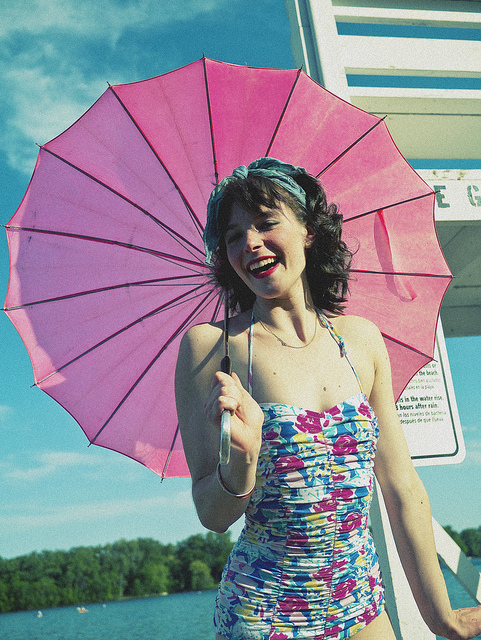

In [18]:
print(bold(f'{image.width}x{image.height} Image'))
print(bold('Image Captions:'))
print('\n'.join(f'{idx}: ' + c['caption'] for idx, c in enumerate(captions)))
image

In [19]:
print(bold('Objects present:'))

for id_, object_label in enumerate(labels):
    cat = coco.cats[object_label['category_id']]
    supercategory, name = cat['supercategory'], cat['name']
    print(f'{id_}: {name} ({supercategory})')

Objects present:
0: umbrella (accessory)
1: person (person)


### Select Object in Image

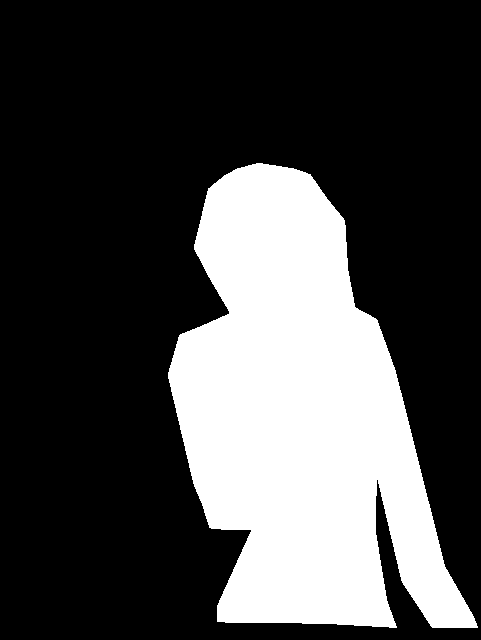

In [20]:
random_object_select = False #@param {type:"boolean"}
object_idx = 1 # @param {type: "integer"}
segmented_object = (labels[object_idx] 
                    if not random_object_select else random.choice(labels))

object_mask = Image.fromarray(coco.annToMask(segmented_object)*255)
object_mask

### Select Caption of Image & Skill

In [21]:
random_caption_select = False #@param {type:"boolean"}
caption_idx = 0 # @param {type: "integer"}
skill = 'gender' # @param {type: "string"}

In [22]:
selected_caption = (captions[caption_idx] 
                    if not random_caption_select else random.choice(captions))['caption']
plt.imshow(np.array(image)); plt.axis('off')
coco.showAnns(labels)

In [23]:
checker = skillsChecker()
_, modified_caption = checker.change_captions_skill([selected_caption], skill)[0]
modified_caption = modified_caption[0]

In [24]:
print(bold('Original Caption'))
print(selected_caption)

print(bold('Modified Caption'))
print(modified_caption)

Original Caption
Woman in swim suit holding parasol on sunny day.
Modified Caption
Man in swim suit holding parasol on sunny day.


## Generate New Image with Inpaiting

In [25]:
input_image = image.resize((512,512), Image.BILINEAR)
input_mask = object_mask.resize((512,512), Image.NEAREST)

In [26]:
import cv2

dilation_size = 25

kernel = np.ones((dilation_size, dilation_size), np.uint8)
input_mask_dilated = cv2.dilate(np.array(input_mask), kernel, iterations=1)
input_mask_dilated = Image.fromarray(input_mask_dilated)

In [27]:
prompt = "" # @param {type:"string"}
dilate_mask = True # @param {type:"boolean"}

prompt = modified_caption if not prompt else prompt

In [28]:
guidance_scale = 7.5
num_samples = 5
generator = torch.Generator(device="cuda")

output = pipe(
    prompt=prompt,
    image=input_image,
    mask_image=input_mask_dilated if dilate_mask else input_mask,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples
)

output_images = output.images

## Display Results

In [29]:
if input_image not in output_images:
    output_images.insert(0, input_image)

In [42]:
tokenized_prompt = clip.tokenize(prompt).to(device)
# tokenized_prompt = clip.tokenize(selected_caption).to(device)

tensor_images = torch.stack([preprocess(img) for img in output_images]).to(device)
with torch.no_grad():
    image_features = clip_model.encode_image(tensor_images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features = clip_model.encode_text(tokenized_prompt).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

clip_scores = (text_features @ image_features.T).squeeze()
clip_scores = [f'{score:.4f}' for score in clip_scores.tolist()]

Original: Woman in swim suit holding parasol on sunny day.
Modified: Man in swim suit holding parasol on sunny day.
clip_scores ['0.2049', '0.3030', '0.2949', '0.2793', '0.2796', '0.2799']


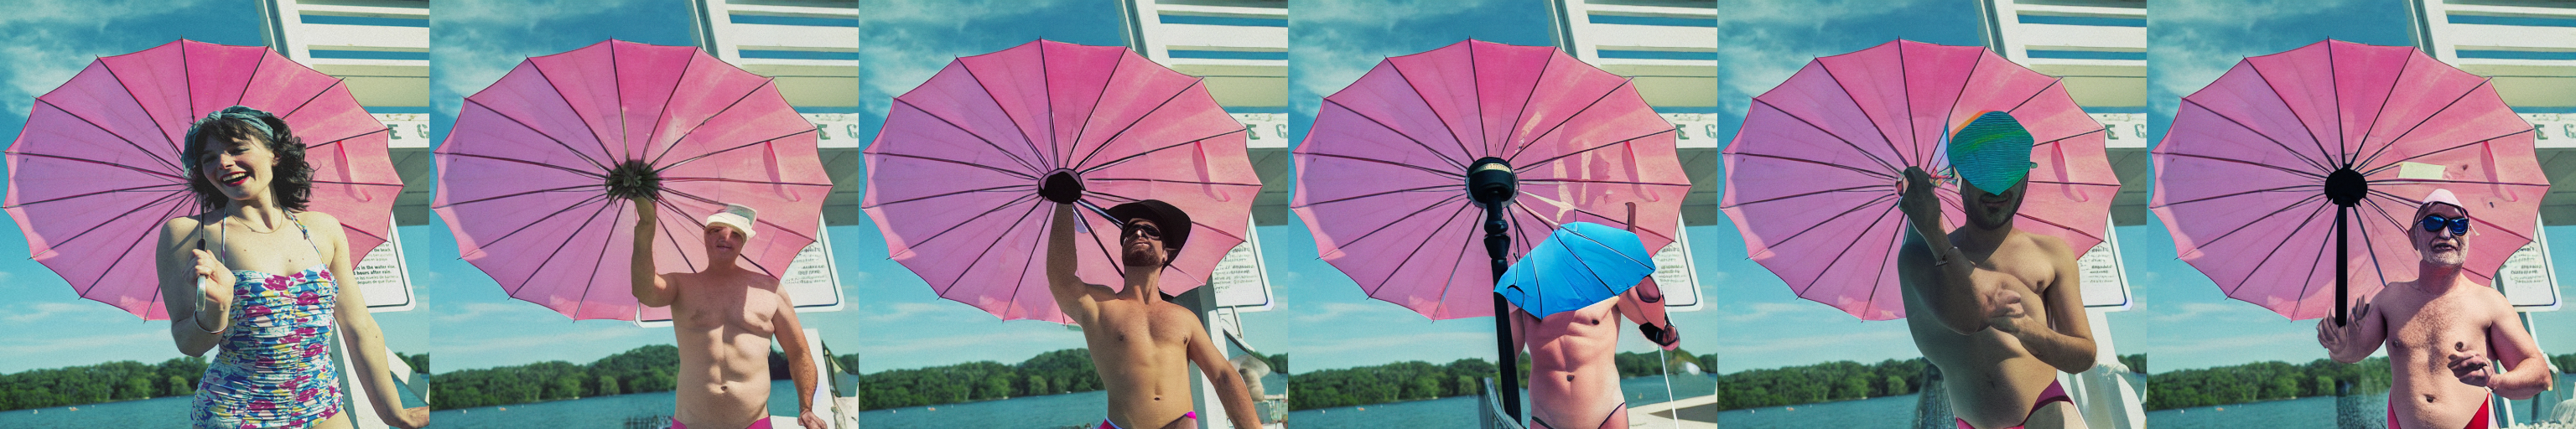

In [43]:
print(bold('Original:'), selected_caption)
print(bold('Modified:'), prompt)
print(bold('clip_scores'), clip_scores)
image_grid(output_images, 1, num_samples + 1)